In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("application_train.csv")

In [3]:
# 欠損値の補完
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode())
    else:
        df[col] = df[col].fillna(df[col].mean())

In [4]:
#objectの数値変換
df = pd.get_dummies(df)

In [5]:
df.shape

(307511, 246)

In [6]:
#相関系数の高い値を特徴量として活用
X = df.loc[:, ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","NAME_EDUCATION_TYPE_Higher education","CODE_GENDER_F","CODE_GENDER_M","DAYS_BIRTH","DAYS_EMPLOYED"]]
y = df.loc[:, ['TARGET']]

# 全特徴量データを利用
X1= df[df.columns[df.columns != 'TARGET']]
y = df.loc[:, 'TARGET']

# 【問題1】クロスバリデーション
事前学習期間では検証用データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

In [7]:
#　交差検証モデルの利用しデータごとに４分割
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=4, shuffle=True, random_state=42)

rfc = RandomForestClassifier()
scores = cross_val_score(rfc, X=X, y=y, cv=kf)

In [8]:
print('Cross-Validation scores: {}'.format(scores))
print("Mean score: {}".format(scores.mean()))

Cross-Validation scores: [0.91844221 0.9174146  0.91794792 0.91864927]
Mean score: 0.9181135001212015


In [9]:
for train_index, test_index in kf.split(X, y):
    print("train_index:", train_index, "test_index:", test_index)
    print(train_index.shape)

train_index: [     1      3      4 ... 307508 307509 307510] test_index: [     0      2      6 ... 307498 307502 307503]
(230633,)
train_index: [     0      2      3 ... 307506 307507 307509] test_index: [     1      4      9 ... 307497 307508 307510]
(230633,)
train_index: [     0      1      2 ... 307506 307508 307510] test_index: [     3      8     14 ... 307505 307507 307509]
(230633,)
train_index: [     0      1      2 ... 307508 307509 307510] test_index: [     5      7     13 ... 307501 307504 307506]
(230634,)


In [10]:
kf.get_n_splits(X1)
for train_index, test_index in kf.split(X1, y):
    print("train_index:", train_index, "test_index:", test_index)
    print(train_index.shape)

train_index: [     1      3      4 ... 307508 307509 307510] test_index: [     0      2      6 ... 307498 307502 307503]
(230633,)
train_index: [     0      2      3 ... 307506 307507 307509] test_index: [     1      4      9 ... 307497 307508 307510]
(230633,)
train_index: [     0      1      2 ... 307506 307508 307510] test_index: [     3      8     14 ... 307505 307507 307509]
(230633,)
train_index: [     0      1      2 ... 307508 307509 307510] test_index: [     5      7     13 ... 307501 307504 307506]
(230634,)


# 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。最適なパラメータを探していくことを パラメータチューニング と呼びます。パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。

scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。

sklearn.model_selection.GridSearchCV — scikit-learn 0.21.3 documentation

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

In [11]:
# グリッドサーチで決定木の学習モデル
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

param = {'n_estimators': [1, 10, 20, 30, 40, 50]}

rfc = RandomForestClassifier(random_state=0, )
gscv = GridSearchCV(estimator=rfc, param_grid=param, scoring='roc_auc', cv=4)
gscv.fit(X_train, y_train)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [12]:
print('グリッドサーチ・ランダムフォレストモデルのbest parameter      :  %d'  %gscv.best_estimator_.n_estimators)
print('通常のランダムフォレストモデルの parameter   :  %d'  %rfc.n_estimators)

グリッドサーチ・ランダムフォレストモデルのbest parameter      :  50
通常のランダムフォレストモデルの parameter   :  100


In [13]:
y_pred1 = rfc.predict_proba(X_test)
y_pred2 = gscv.predict_proba(X_test)

In [14]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred1[:,1])
score = auc(fpr, tpr)

fpr2, tpr2, _2 = roc_curve(y_test, y_pred2[:,1])
score2 = auc(fpr2, tpr2)

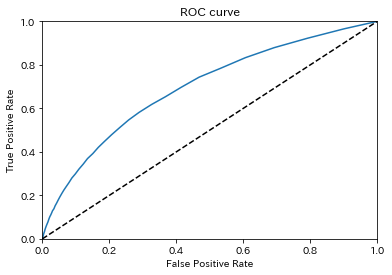

In [15]:
# ROC 曲線の描写
plt.plot(fpr, tpr, '-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show();

In [16]:
from sklearn.metrics import roc_auc_score
print('通常のランダムフォレストモデルによるaucスコア         :  %.3f'  %score)
print('グリッドサーチ・ランダムフォレストモデルによるaucスコア   :  %.3f'  %score2)

通常のランダムフォレストモデルによるaucスコア         :  0.695
グリッドサーチ・ランダムフォレストモデルによるaucスコア   :  0.684


In [17]:
GSCV_score = pd.DataFrame(gscv.cv_results_)
display(GSCV_score)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.286906,0.019139,0.028057,0.003250,1,{'n_estimators': 1},0.534900,0.537944,0.531098,0.539731,0.535918,0.003275,6
1,2.581844,0.069606,0.152274,0.001084,10,{'n_estimators': 10},0.642604,0.638819,0.629598,0.638869,0.637473,0.004798,5
2,5.383876,0.144424,0.296526,0.003764,20,{'n_estimators': 20},0.669436,0.659229,0.657370,0.663568,0.662401,0.004643,4
3,8.227601,0.330586,0.435556,0.009399,30,{'n_estimators': 30},0.679086,0.672738,0.668668,0.673398,0.673472,0.003713,3
4,12.107908,2.102439,0.749241,0.289391,40,{'n_estimators': 40},0.684059,0.680463,0.677131,0.678593,0.680062,0.002592,2
5,13.606953,0.850009,0.708054,0.004450,50,{'n_estimators': 50},0.686645,0.683968,0.681553,0.683532,0.683925,0.001815,1


# 【問題3】Kernelからの調査
KaggleのKernelから様々なアイデアを見つけ出して、列挙してください。

- 調査１<br>
多くの説明にLghitGBMの利用が進められていたのでこの手法を利用する。
またLightGBMは近年のKaggleで高パフォーマンス叩き出している。パフォーマンスはハイパーパラメーターの選択に大きく依存する

- 調査２<br>
不必要なパラメータの削除している例などもあり、不必要なデータを見極めることが重要

# 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。

その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。

## 試行１
まずは単純に特徴量を絞り精度出るのか検証

In [18]:
#最大表示列数の指定
pd.set_option('display.max_columns', 246)
df_corr = df.corr()
#ターゲットとの相関確認
df_corr.loc[['TARGET']]

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business

In [19]:
# 利用する特徴量1１に絞る
X2 = df.loc[:, ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","NAME_EDUCATION_TYPE_Higher education","CODE_GENDER_F","CODE_GENDER_M","DAYS_BIRTH","DAYS_EMPLOYED",'AMT_CREDIT', 'AMT_GOODS_PRICE','DAYS_REGISTRATION']]
y2 = df.loc[:, ['TARGET']]

In [20]:
X2.shape

(307511, 11)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=0)

param = {'n_estimators': [1, 10, 20, 30, 40, 50]}

rfc = RandomForestClassifier(random_state=0, )
gscv = GridSearchCV(estimator=rfc, param_grid=param, scoring='roc_auc', cv=4)
gscv.fit(X_train, y_train.values.ravel())
rfc.fit(X_train, y_train)

/Users/katouyuuya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
print('グリッドサーチ・ランダムフォレストモデルのbest parameter      :  %d'  %gscv.best_estimator_.n_estimators)

グリッドサーチ・ランダムフォレストモデルのbest parameter      :  50


In [23]:
from sklearn.metrics import roc_curve

y_pred2 = gscv.predict(X_test)
y_pred2_prob = gscv.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred2_prob[:, 1])
score = auc(fpr, tpr)
score

0.704056235338614

In [24]:
from sklearn.metrics import roc_auc_score
print('グリッドサーチ・ランダムフォレストモデルによる予測値   :  %.3f'  %score)

グリッドサーチ・ランダムフォレストモデルによる予測値   :  0.704


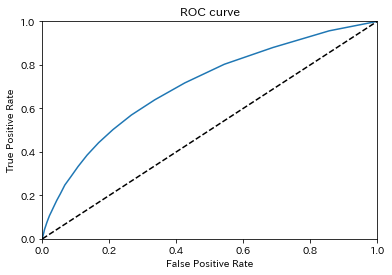

In [25]:
# ROC 曲線の描写
plt.plot(fpr, tpr, '-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show();

[考察]今回増やした特徴量はあまり良くない。そのため全てのデータをどう利用するか検討必要。

## 試行２
今回は、LightGBMを利用する。

In [161]:
X_train, X_valid, y_train, y_valid = train_test_split(X2, y2, test_size=0.20, random_state=42)

In [162]:
print("Training shape: ", X_train.shape)
print("Testing  shape: ", X_valid.shape)

Training shape:  (246008, 11)
Testing  shape:  (61503, 11)


In [163]:
import lightgbm as lgb

In [164]:
params = {
    'application': 'binary',
    'learning_rate': 0.01,
    'num_leaves': 34,
    'max_depth': 5,
    'feature_fraction': 0.9,
    'scale_pos_weight': 2,
    'reg_alpha': 0.05,
    'reg_lambda': 0.1}
model = lgb.train(params, lgb.Dataset(X_train, y_train), 1000, [lgb.Dataset(X_train, y_train), lgb.Dataset(X_valid, y_valid)], verbose_eval=10, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.27408	valid_1's binary_logloss: 0.273429
[20]	valid_0's binary_logloss: 0.27018	valid_1's binary_logloss: 0.269672
[30]	valid_0's binary_logloss: 0.267783	valid_1's binary_logloss: 0.267409
[40]	valid_0's binary_logloss: 0.266339	valid_1's binary_logloss: 0.266071
[50]	valid_0's binary_logloss: 0.265485	valid_1's binary_logloss: 0.265309
[60]	valid_0's binary_logloss: 0.264997	valid_1's binary_logloss: 0.264916
[70]	valid_0's binary_logloss: 0.264718	valid_1's binary_logloss: 0.264733
[80]	valid_0's binary_logloss: 0.264619	valid_1's binary_logloss: 0.264747
[90]	valid_0's binary_logloss: 0.264673	valid_1's binary_logloss: 0.264869
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.26466	valid_1's binary_logloss: 0.264716


In [165]:
from sklearn.metrics import roc_auc_score
preds = model.predict(X_valid)
roc_auc_score(y_valid, preds)

0.7299259248450617

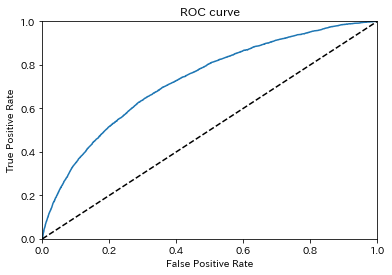

In [166]:
# ROC 曲線の描写
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_valid, preds)

plt.plot(fpr, tpr, '-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show();

<strong>[結果]</strong><br>
LightGBMで同じ特徴量を活用するだけでも精度が上がった。また、計算の処理速度もかなり早い<br>

<strong>[考察]</strong><br>
しかしながら自身の作った前処理済みデータは数値のみ利用したカーネルのデータよりも精度落ちていた。そのため特徴量の取捨選択を必要に感じる。内容理解しないままLIghtGBM利用しているので、原理などについても勉強の必要あり。

# 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

### 最終的には試行2で利用したモデルを使いapllication_testデータの推定を行う。

In [167]:
df2 = pd.read_csv('application_test.csv')

# 欠損値の補完
for col in df2.columns:
    if df2[col].dtype == 'object':
        df2[col] = df2[col].fillna(df2[col].mode())
    else:
        df2[col] = df2[col].fillna(df2[col].mean())
        
#objectの数値変換
df2 = pd.get_dummies(df2)
df2.shape

(48744, 242)

In [168]:
X4 = df2.loc[:, ["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","NAME_EDUCATION_TYPE_Higher education","CODE_GENDER_F","CODE_GENDER_M","DAYS_BIRTH","DAYS_EMPLOYED",'AMT_CREDIT', 'AMT_GOODS_PRICE','DAYS_REGISTRATION']]

In [169]:
pred_submit = model.predict(X4)

In [170]:
pred_submit

array([0.10139808, 0.14137618, 0.06831017, ..., 0.09410715, 0.10072232,
       0.16016514])

In [177]:
predict = [0 if i < 0.4 else 1 for i in pred_submit]

In [178]:
df2_SK = df2['SK_ID_CURR']
df2_SK.columns = ['SK_ID_CURR']
df2_SK

0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64

In [179]:
ALL_data = pd.DataFrame(predict)
ALL_data.columns = ['TARGET']
ALL_data

,TARGET
0,0
1,0
2,0
3,0
4,0
...,...
48739,0
48740,0
48741,0
48742,0


In [180]:
#データの結合
sample =pd.concat([df2_SK, ALL_data], axis=1)

In [181]:
sample

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0
...,...,...
48739,456221,0
48740,456222,0
48741,456223,0
48742,456224,0


In [182]:
sample.to_csv('submit_020502.csv', index=None)

## Kaglle score<br>
- Private Score: 0.64546
- Public Score: 0.66037